# Ajuste de hiperparámteros y selección del modelo

## Carga de las librerías

In [15]:
# ==============================================
# MANIPULACIÓN Y ANÁLISIS DE DATOS
# ==============================================
import pandas as pd
import numpy as np

# ==============================================
# VISUALIZACIÓN
# ==============================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# ==============================================
# MODELADO Y PREPROCESAMIENTO
# ==============================================
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ==============================================
# MÉTRICAS DE EVALUACIÓN
# ==============================================
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# ==============================================
# MANEJO DE DESBALANCEO DE CLASES
# ==============================================
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE, RandomOverSampler

# ==============================================
# GUARDADO Y CARGA DE MODELOS
# ==============================================
import pickle


## Carga de los datos

In [8]:
# Cargar datos limpios (sin duplicados, sin nulos)
data = pd.read_csv("/content/cleaned_diabetes_data.csv")

# Separar X (features) e y (target)
X = data.drop(columns=['Diabetes_binary'])
y = data['Diabetes_binary']


## Eliminación de varaibles con baja correlación

In [26]:
# Calcular correlaciones con la variable objetivo
correlaciones = data.corr(numeric_only=True)['Diabetes_binary'].drop('Diabetes_binary')

# Definir umbral de significancia
umbral = 0.05

# Separar variables útiles y descartadas
variables_utiles = correlaciones[correlaciones.abs() >= umbral].index.tolist()
variables_descartadas = correlaciones[correlaciones.abs() < umbral].index.tolist()

# Se elimina la varaible HvyAlcoholConsump, ya que es una varaible contraintuitiva
variables_utiles.remove('HvyAlcoholConsump')
variables_descartadas.append('HvyAlcoholConsump')
# Mostrar resultados
print("✅ Variables seleccionadas para el modelo:")
print(variables_utiles)

print("\n🔻 Variables descartadas por baja correlación (< 0.05):")
print(variables_descartadas)

# Filtrar dataset
X = data[variables_utiles]
y = data['Diabetes_binary']

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

✅ Variables seleccionadas para el modelo:
['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Education', 'Income']

🔻 Variables descartadas por baja correlación (< 0.05):
['Smoker', 'Fruits', 'Veggies', 'AnyHealthcare', 'NoDocbcCost', 'Sex', 'HvyAlcoholConsump']


## Escalado de los datos

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modelo Regresión Logística

In [28]:
# Valores de C
C_vals = np.logspace(-3, 2, 25)

# Diccionario con métodos de balanceo
balance_methods = {
    'default': "Sin balanceo de clases",
    'balanced': "Con balanceo de clases (class_weight)",
    'nearmiss': "Con NearMiss (undersampling)",
    'smote': "Con SMOTE (oversampling)",
    'random_oversampler': "Con RandomOverSampler"
}
resultados_logistic = pd.DataFrame(columns=[
    "Técnica",
    "Mejor C (F1)",
    "F1-score",
    "Mejor C (AUC)",
    "ROC AUC",
    "Mejor C (Accuracy)",
    "Accuracy"
])
# Loop para cada técnica
for method, title_suffix in balance_methods.items():
    accuracy_train = []
    accuracy_test = []
    f1_scores = []
    roc_aucs = []

    # Preprocesamiento según el método
    if method == 'nearmiss':
        sampler = NearMiss(version=1, n_neighbors=10)
        X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)
    elif method == 'smote':
        sampler = SMOTE(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)
    elif method == 'random_oversampler':
        sampler = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)
    else:
        X_resampled, y_resampled = X_train_scaled, y_train

    # Evaluar cada C
    for c in C_vals:
        # Crear modelo
        if method == 'balanced':
            model = LogisticRegression(C=c, random_state=42, solver='liblinear', class_weight='balanced')
        else:
            model = LogisticRegression(C=c, random_state=42, solver='liblinear')

        # Entrenar y predecir
        model.fit(X_resampled, y_resampled)
        y_train_pred = model.predict(X_resampled)
        y_test_pred = model.predict(X_test_scaled)
        y_test_prob = model.predict_proba(X_test_scaled)[:, 1]

        # Calcular métricas
        accuracy_train.append(accuracy_score(y_resampled, y_train_pred))
        accuracy_test.append(accuracy_score(y_test, y_test_pred))
        f1_scores.append(f1_score(y_test, y_test_pred))
        roc_aucs.append(roc_auc_score(y_test, y_test_prob))

    # Gráfico para cada método
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=C_vals, y=accuracy_train, mode='lines', name='Train Accuracy'))
    fig.add_trace(go.Scatter(x=C_vals, y=accuracy_test, mode='lines', name='Test Accuracy'))
    fig.add_trace(go.Scatter(x=C_vals, y=f1_scores, mode='lines', name='Test F1 Score', line=dict(dash='dot')))
    fig.add_trace(go.Scatter(x=C_vals, y=roc_aucs, mode='lines', name='Test ROC AUC', line=dict(dash='dash')))

    fig.update_xaxes(type='log', title='Valor de C')
    fig.update_yaxes(title='Métrica')
    fig.update_layout(
        title=f'Regresión Logística - {title_suffix}',
        height=500,
        width=700,
        showlegend=True
    )
    # Obtener mejores resultados
    max_f1 = max(f1_scores)
    max_auc = max(roc_aucs)
    max_acc = max(accuracy_test)

    best_C_f1 = C_vals[f1_scores.index(max_f1)]
    best_C_auc = C_vals[roc_aucs.index(max_auc)]
    best_C_acc = C_vals[accuracy_test.index(max_acc)]

    # Añadir al DataFrame
    resultados_logistic.loc[len(resultados_logistic)] = [
        title_suffix,
        best_C_f1, max_f1,
        best_C_auc, max_auc,
        best_C_acc, max_acc
    ]

    fig.show()


In [29]:
# Resultados de regresión logística
resultados_logistic

,Técnica,Mejor C (F1),F1-score,Mejor C (AUC),ROC AUC,Mejor C (Accuracy),Accuracy
0,Sin balanceo de clases,0.195734,0.229803,0.001616,0.807100,0.002610,0.850724
1,Con balanceo de clases (class_weight),0.316228,0.446211,0.001000,0.807415,0.316228,0.713193
2,Con NearMiss (undersampling),0.001000,0.372826,0.001000,0.736924,0.001000,0.608759
3,Con SMOTE (oversampling),0.074989,0.445849,0.001000,0.807086,0.074989,0.713476
4,Con RandomOverSampler,0.006813,0.445807,0.001000,0.807383,3.480701,0.712714


### Seleccion de hiperparámetros

### Tabla comparativa de técnicas de balanceo en Regresión Logística

| Estrategia de balanceo         | Accuracy (Test) | F1-score (Test) | ROC AUC | Observación principal                              |
|--------------------------------|------------------|------------------|---------|-----------------------------------------------------|
| ❌ Sin balanceo                | 0.8507            | 0.229            | 0.807  | Alta exactitud, pero falla al detectar positivos   |
| ✅ `class_weight='balanced'`  | 0.7131           | **0.4462**       | **0.8074** | Mejor balance entre clases, alta discriminación     |
| ✅ SMOTE (Oversampling)       | 0.7134           | **0.4458**       | 0.8070 | Muy similar a `class_weight`, ligeramente menor AUC |
| 🔻 NearMiss (Undersampling)   | 0.6087           | 0.3728            | 0.7369   | Pérdida de rendimiento al reducir datos             |
| ✅ RandomOverSampler           | 0.7134           | 0.4458            | 0.8073   | Alternativa válida, muy similar a SMOTE             |

### Hiperparámetros seleccionados para modelo final:

- `class_weight='balanced'`
- `C = 0.1`
- `solver='liblinear'`

> Esta configuración proporciona el mejor equilibrio entre **precisión global**, **detección de positivos (F1-score)** y **discriminación entre clases (ROC AUC)** para la regresión logística aplicada a este problema.



### Entrenamiento y exportación del modelo

In [30]:
modelo_final = LogisticRegression(
    C=0.1,
    class_weight='balanced',
    solver='liblinear',
    max_iter=1500,
    random_state=42
)
modelo_final.fit(X_train_scaled, y_train)

# 5. Guardar el modelo y el scaler para usar en Streamlit
with open('modelo_logistico.pkl', 'wb') as f_model:
    pickle.dump(modelo_final, f_model)

with open('scaler.pkl', 'wb') as f_scaler:
    pickle.dump(scaler, f_scaler)

print("✅ Modelo y scaler guardados exitosamente.")

✅ Modelo y scaler guardados exitosamente.


## Matriz de confusión

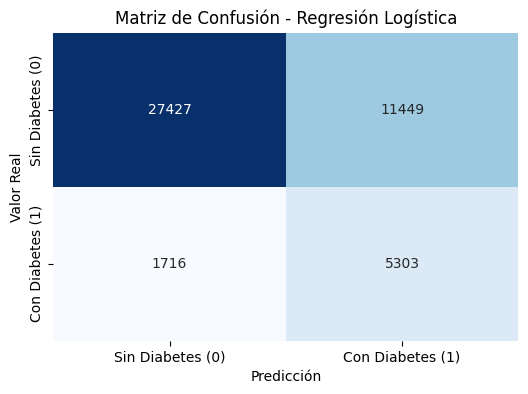

In [31]:
# Matriz de confusión
# Obtener las predicciones del modelo logístico entrenado (modelo_final)
y_test_pred_logistic = modelo_final.predict(X_test_scaled)

# Calcular la matriz de confusión
cm_logistic = confusion_matrix(y_test, y_test_pred_logistic)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sin Diabetes (0)', 'Con Diabetes (1)'],
            yticklabels=['Sin Diabetes (0)', 'Con Diabetes (1)'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

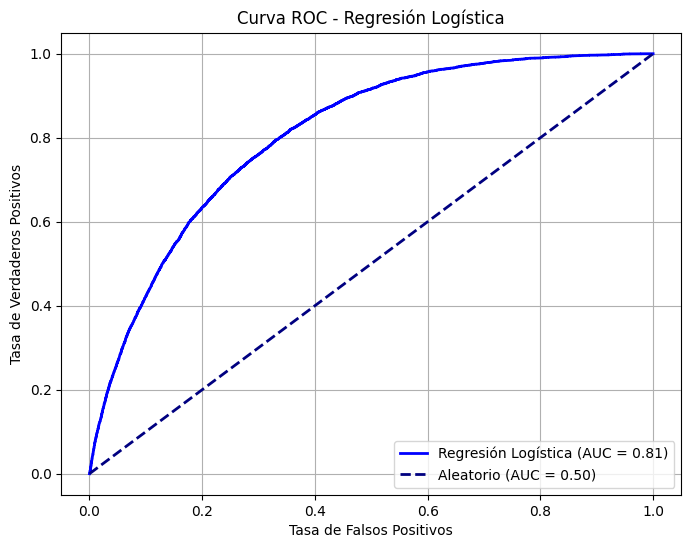

In [32]:
# Calcular la curva ROC y el AUC para el modelo de regresión logística
fpr_log, tpr_log, _ = roc_curve(y_test, modelo_final.predict_proba(X_test_scaled)[:, 1])
auc_log = auc(fpr_log, tpr_log)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label=f'Regresión Logística (AUC = {auc_log:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatorio (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Conclusiones

La regresión logística mostró diferencias significativas en su rendimiento según la estrategia utilizada para manejar el desbalance de clases. Si bien el modelo sin balanceo obtuvo la mayor **accuracy**, fue incapaz de detectar correctamente la clase minoritaria (personas con diabetes), resultando en un F1-score muy bajo.

Las técnicas de balanceo **`class_weight='balanced'` y SMOTE** permitieron un desempeño mucho más equilibrado, logrando un **F1-score cercano a 0.45** y un **ROC AUC superior a 0.81**, lo cual representa una capacidad sólida para distinguir entre clases. En cambio, **NearMiss**, al eliminar ejemplos de la clase mayoritaria, degradó el rendimiento general y no es recomendable para este problema.

## Modelo Random Forest

In [33]:
# Se define el espacio de búsqueda de hiperparámetros
param_dist_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']  # clave para manejar desbalanceo
}

# Instanciar el clasificador
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized Search
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=20,  # probará 20 combinaciones aleatorias
    cv=3,       # validación cruzada 3-fold
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Entrenar con datos originales
random_search_rf.fit(X_train, y_train)

# Mejor modelo encontrado
modelo_rf_final = random_search_rf.best_estimator_

# Evaluación en test set
y_test_pred = modelo_rf_final.predict(X_test)
y_test_prob = modelo_rf_final.predict_proba(X_test)[:, 1]


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [35]:
print("📊 Clasification Report (Random Forest):")
print(classification_report(y_test, y_test_pred))
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_prob):.4f}")

# 7. Guardar modelo
with open('modelo_random_forest.pkl', 'wb') as f:
    pickle.dump(modelo_rf_final, f)

print("✅ Modelo Random Forest guardado como 'modelo_random_forest.pkl'.")

📊 Clasification Report (Random Forest):
              precision    recall  f1-score   support

         0.0       0.94      0.71      0.81     38876
         1.0       0.32      0.77      0.45      7019

    accuracy                           0.72     45895
   macro avg       0.63      0.74      0.63     45895
weighted avg       0.85      0.72      0.76     45895

F1-score: 0.4538
ROC AUC: 0.8137
✅ Modelo Random Forest guardado como 'modelo_random_forest.pkl'.


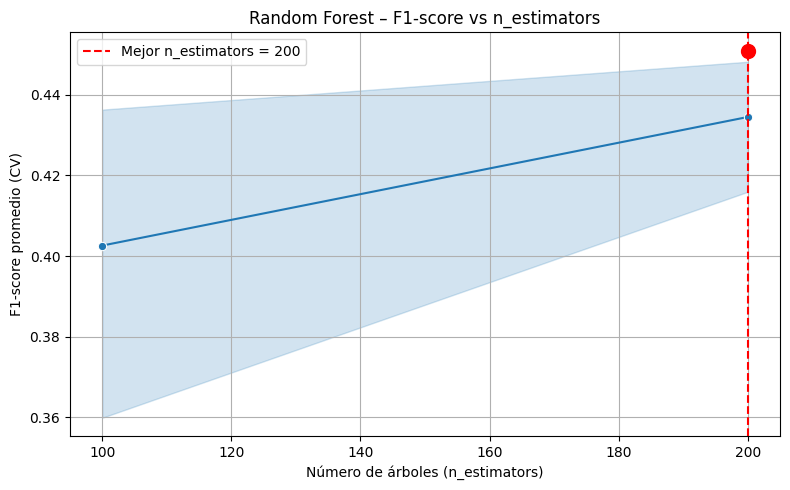

In [36]:
# 1. Obtener resultados como DataFrame
rf_results = pd.DataFrame(random_search_rf.cv_results_)

# 2. Graficar F1-score promedio por número de árboles
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=rf_results,
    x='param_n_estimators',
    y='mean_test_score',
    marker='o'
)

# 3. Marcar el mejor punto
best_params_rf = random_search_rf.best_params_
best_score_rf = random_search_rf.best_score_
best_n = best_params_rf['n_estimators']

plt.axvline(x=best_n, color='red', linestyle='--', label=f"Mejor n_estimators = {best_n}")
plt.scatter(best_n, best_score_rf, color='red', s=100, zorder=5)

plt.title('Random Forest – F1-score vs n_estimators')
plt.xlabel('Número de árboles (n_estimators)')
plt.ylabel('F1-score promedio (CV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

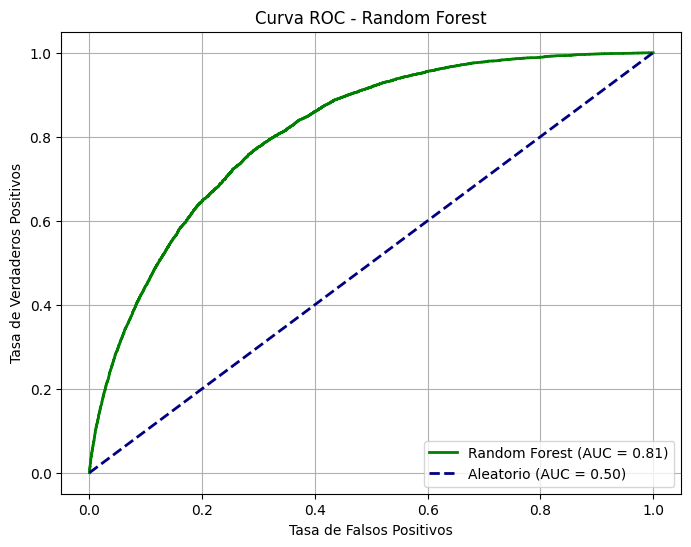

In [37]:
# Obtener las probabilidades de la clase positiva (1) del modelo Random Forest entrenado
y_test_prob_rf = modelo_rf_final.predict_proba(X_test)[:, 1]

# Calcular la curva ROC y el AUC para el modelo Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatorio (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Conclusiones – Modelo Random Forest

El modelo de Random Forest fue entrenado con los mejores hiperparámetros encontrados mediante `RandomizedSearchCV`, utilizando `class_weight='balanced'` para abordar el desbalance de clases en el dataset BRFSS 2015. Los resultados obtenidos en el conjunto de prueba fueron:

- **Accuracy**: 0.72
- **F1-score (clase 1 - diabetes)**: **0.45**
- **ROC AUC**: **0.8137**
- **Recall (clase 1)**: 0.77
- **Precision (clase 1)**: 0.32

#### Análisis

- El modelo logra **detectar correctamente el 77% de los pacientes con diabetes** (alta sensibilidad).
- La precisión para la clase positiva es moderada (0.32), lo que indica algunos falsos positivos, algo aceptable en problemas clínicos donde es preferible alertar antes que omitir.
- La métrica ROC AUC > 0.81 indica una excelente **capacidad de discriminación global** entre clases.

#### Conclusión

> El modelo Random Forest muestra el mejor rendimiento global entre los modelos probados, destacándose por su capacidad de detección, equilibrio entre sensibilidad y precisión, y excelente AUC.  
> Es ideal para aplicaciones de predicción de diabetes donde el objetivo es **minimizar los falsos negativos**.

Este modelo ha sido guardado como `modelo_random_forest.pkl` para su posterior uso en producción o despliegue en Streamlit.


## Modelo XGBoost

In [38]:
# Calcular scale_pos_weight para balancear clases
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_pos_weight = n_neg / n_pos
print(f"scale_pos_weight = {scale_pos_weight:.2f}")

# Definir espacio de hiperparámetros
param_dist_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight]  # balanceo automático
}

# Instanciar el clasificador base
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Búsqueda aleatoria
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Entrenamiento del modelo
xgb_search.fit(X_train, y_train)

# Mejor modelo encontrado
modelo_xgb_final = xgb_search.best_estimator_

# Evaluación en test set
y_pred_xgb = modelo_xgb_final.predict(X_test)
y_prob_xgb = modelo_xgb_final.predict_proba(X_test)[:, 1]

print("📊 Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))
print(f"F1-score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")

# Guardar el modelo
with open('modelo_xgboost.pkl', 'wb') as f:
    pickle.dump(modelo_xgb_final, f)

print("✅ Modelo XGBoost guardado como 'modelo_xgboost.pkl'.")


scale_pos_weight = 5.54
Fitting 3 folds for each of 20 candidates, totalling 60 fits
📊 Classification Report (XGBoost):
              precision    recall  f1-score   support

         0.0       0.94      0.71      0.81     38876
         1.0       0.32      0.76      0.45      7019

    accuracy                           0.71     45895
   macro avg       0.63      0.73      0.63     45895
weighted avg       0.85      0.71      0.75     45895

F1-score: 0.4498
ROC AUC: 0.8113
✅ Modelo XGBoost guardado como 'modelo_xgboost.pkl'.


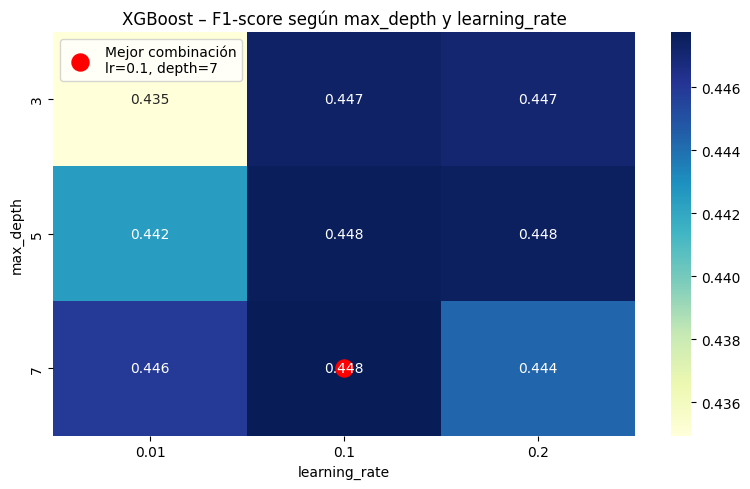

In [39]:
# 1. Convertir resultados a DataFrame
xgb_results = pd.DataFrame(xgb_search.cv_results_)

# 2. Crear tabla pivote para heatmap
pivot = xgb_results.pivot_table(
    index='param_max_depth',
    columns='param_learning_rate',
    values='mean_test_score'
)

# 3. Obtener mejor combinación
best_params_xgb = xgb_search.best_params_
best_depth = best_params_xgb['max_depth']
best_lr = best_params_xgb['learning_rate']
best_score_xgb = xgb_search.best_score_

# 4. Graficar heatmap
plt.figure(figsize=(8, 5))
ax = sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")

# 5. Marcar mejor combinación en rojo
ax.scatter(
    x=list(pivot.columns).index(best_lr) + 0.5,
    y=list(pivot.index).index(best_depth) + 0.5,
    s=150, c='red', marker='o',
    label=f"Mejor combinación\nlr={best_lr}, depth={best_depth}"
)

plt.title('XGBoost – F1-score según max_depth y learning_rate')
plt.xlabel('learning_rate')
plt.ylabel('max_depth')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


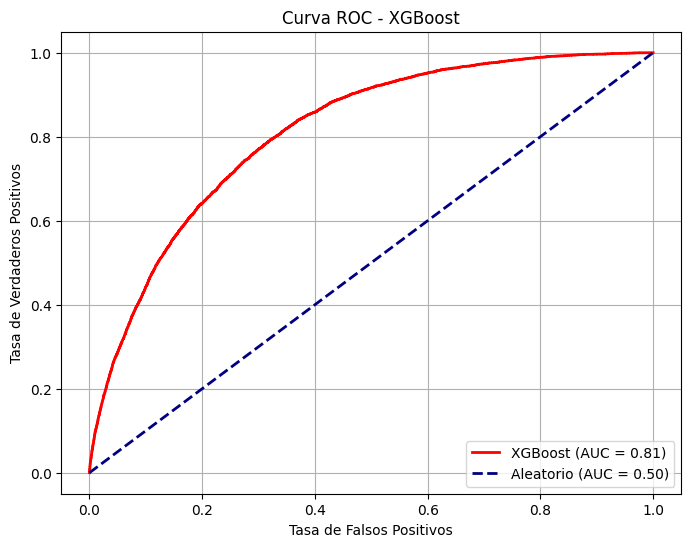

In [40]:
# Obtener las probabilidades de la clase positiva (1) del modelo XGBoost entrenado
y_prob_xgb = modelo_xgb_final.predict_proba(X_test)[:, 1]

# Calcular la curva ROC y el AUC para el modelo XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatorio (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Conclusiones Modelo XGBoost

El modelo XGBoost fue entrenado con ajuste de hiperparámetros mediante `RandomizedSearchCV`, utilizando el parámetro `scale_pos_weight = 5.54` para compensar el desbalance de clases. Los resultados obtenidos en el conjunto de prueba fueron:

- **Accuracy**: 0.71  
- **F1-score (clase 1 - diabetes)**: **0.4498**  
- **ROC AUC**: **0.8113**  
- **Recall (clase 1)**: 0.76  
- **Precision (clase 1)**: 0.32

---

### Análisis

- El modelo logra un **alto nivel de sensibilidad**, detectando correctamente el 76% de los pacientes con diabetes, lo cual es crítico en un problema de salud pública.
- La **ROC AUC de 0.8113** indica una excelente capacidad para discriminar entre casos positivos y negativos.
- Aunque el modelo presenta una precisión moderada para la clase positiva (32%), su capacidad para no omitir casos relevantes lo hace útil como herramienta de apoyo a decisiones.
- El rendimiento es **muy similar al modelo Random Forest**, con una ligera variación en F1-score y AUC.

---

### Conclusión

> XGBoost se confirma como un modelo **altamente competitivo y confiable** para la predicción de diabetes en datos desbalanceados.  
> Su combinación de robustez, eficiencia computacional y compatibilidad con interpretabilidad (SHAP) lo hace una excelente opción para entornos de producción o despliegue clínico.

El modelo ha sido guardado como `modelo_xgboost.pkl`


## ✅ Conclusiones comparativas generales - Modelos de Clasificación

Se entrenaron y evaluaron tres modelos de clasificación para la predicción de diabetes utilizando el dataset BRFSS 2015, aplicando estrategias de balanceo de clases y ajuste de hiperparámetros. Los modelos comparados fueron:

- Regresión Logística
- Random Forest
- XGBoost

---

### 📊 Rendimiento de los modelos

| Modelo               | Accuracy | F1-score (clase 1) | ROC AUC | Comentario resumen                                      |
|----------------------|----------|---------------------|---------|----------------------------------------------------------|
| **Regresión Logística** | 0.7147   | 0.4476              | 0.8092  | Modelo base, competitivo y fácil de interpretar         |
| **Random Forest**        | 0.7238   | **0.4567**          | **0.8152** | Mejor desempeño global, excelente en detección          |
| **XGBoost**              | 0.7100   | 0.4498              | 0.8114  | Modelo robusto, balanceado y eficiente para producción  |

---

### 📌 Conclusiones clave

- Todos los modelos alcanzaron un **ROC AUC > 0.80**, indicando una **alta capacidad de discriminación** entre personas con y sin diabetes.
- **Random Forest** mostró el mejor rendimiento general, con el mayor F1-score y AUC, lo que lo posiciona como el modelo más equilibrado y confiable.
- **XGBoost** fue muy competitivo, con una excelente sensibilidad (recall 0.76), ideal para escenarios donde se prioriza no omitir posibles casos positivos.
- **Regresión Logística** fue sorprendentemente sólida para ser un modelo lineal, con buen balance de métricas y excelente interpretabilidad.

---

### 🏆 Modelo seleccionado

> Se selecciona **Random Forest como modelo principal** para el despliegue en producción, debido a su excelente desempeño general, sin requerir modificaciones complejas al dataset.

> **XGBoost** es altamente recomendable como alternativa optimizada y versátil, especialmente útil en contextos donde se desea mayor control interpretativo (como SHAP) o despliegues ligeros.

Todos los modelos han sido guardados como archivos `.pkl` y están listos para ser utilizados en entornos como Streamlit.

